In [8]:
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from plot_utils import *
import sys
sys.path.append("../")
from difficulty.metrics.metric_utils import combine_metrics_into_df, select_all_replicates, average_columns


NUM_BINS = 100
QUANTILE_LOW = 0.05
QUANTILE_HIGH = 0.95
SUBPLOTS_PER_ROW = 4


def plot_distributions(ax, x, values, title="", color="black", use_median=False):
    # for each value in values, get median, low and high quantiles
    y, y_low, y_high = [], [], []
    for value in values:
        y.append(np.median(value) if use_median else np.mean(value))
        if value.dtype != bool:
            y_low.append(np.quantile(value, QUANTILE_LOW))
            y_high.append(np.quantile(value, QUANTILE_HIGH))
    if len(y_low) > 0:
        ax.fill_between(x, y_low, y_high, color=color, alpha=0.2)
    ax.plot(x, y, color=color, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("Binned rank")
    ax.set_ylabel("Value per replicate")


def distributions_by_model(metrics_dir, use_median):
    df, metrics, (_, models, replicates) = combine_metrics_into_df(metrics_dir)
    metrics = order_metrics(metrics)
    models = order_models(models)
    # prepare subplots
    bin_thresholds = np.floor(np.linspace(0, NUM_BINS - 1, len(df)))
    n_rows = int(np.ceil(len(metrics) / SUBPLOTS_PER_ROW))
    fig = plt.figure(figsize=(4 * n_rows, 4 * SUBPLOTS_PER_ROW), constrained_layout=True)
    grid = matplotlib.gridspec.GridSpec(SUBPLOTS_PER_ROW, n_rows, figure=fig)
    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(grid[i // SUBPLOTS_PER_ROW, i % SUBPLOTS_PER_ROW])
        for j, model in enumerate(models.keys()):
            df_replicates = select_all_replicates(df, metric, model)
            # bin examples by rank per model
            replicate_avg = average_columns(df_replicates, use_median=use_median)
            ranks = np.argsort(replicate_avg)
            x = []
            values = []
            for bin in range(NUM_BINS):
                idx = ranks[bin_thresholds == bin]
                x.append(len(idx))
                values.append(df_replicates.iloc[idx].to_numpy())
            x = np.cumsum(x)
            # plot
            plot_distributions(ax, x, values, title=metric, color=CMAP(j / len(models)), use_median=use_median)
    fig.legend(list(models.values()))
    fig.show()

/tmp/ipykernel_39305/3860670404.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


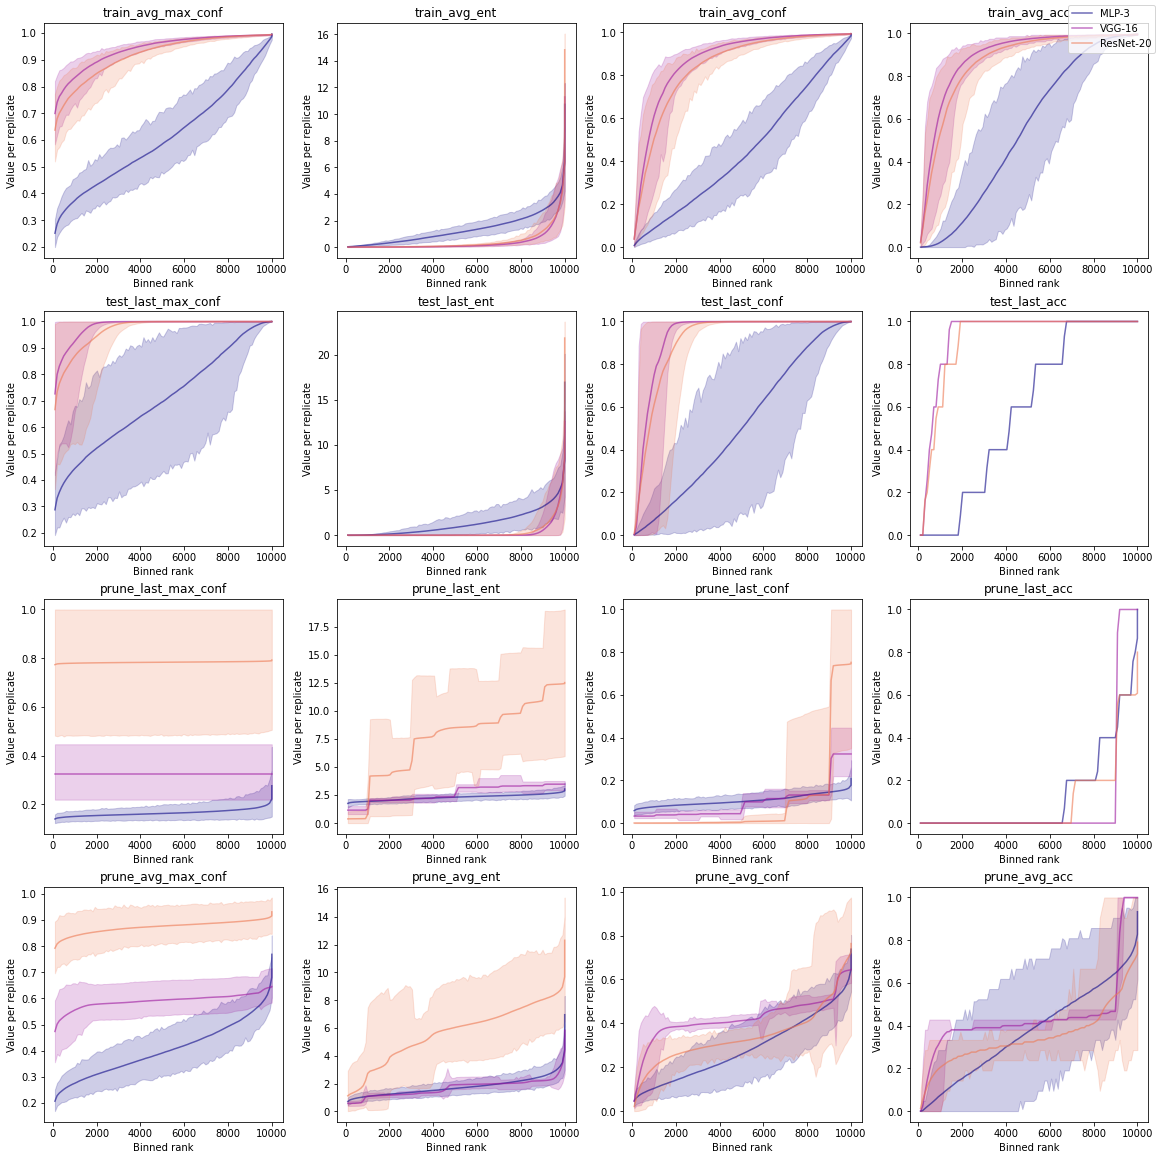

In [9]:
metrics_by_architecture = Path("../outputs")
distributions_by_model(metrics_by_architecture, use_median=False)

/tmp/ipykernel_39305/4208247267.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


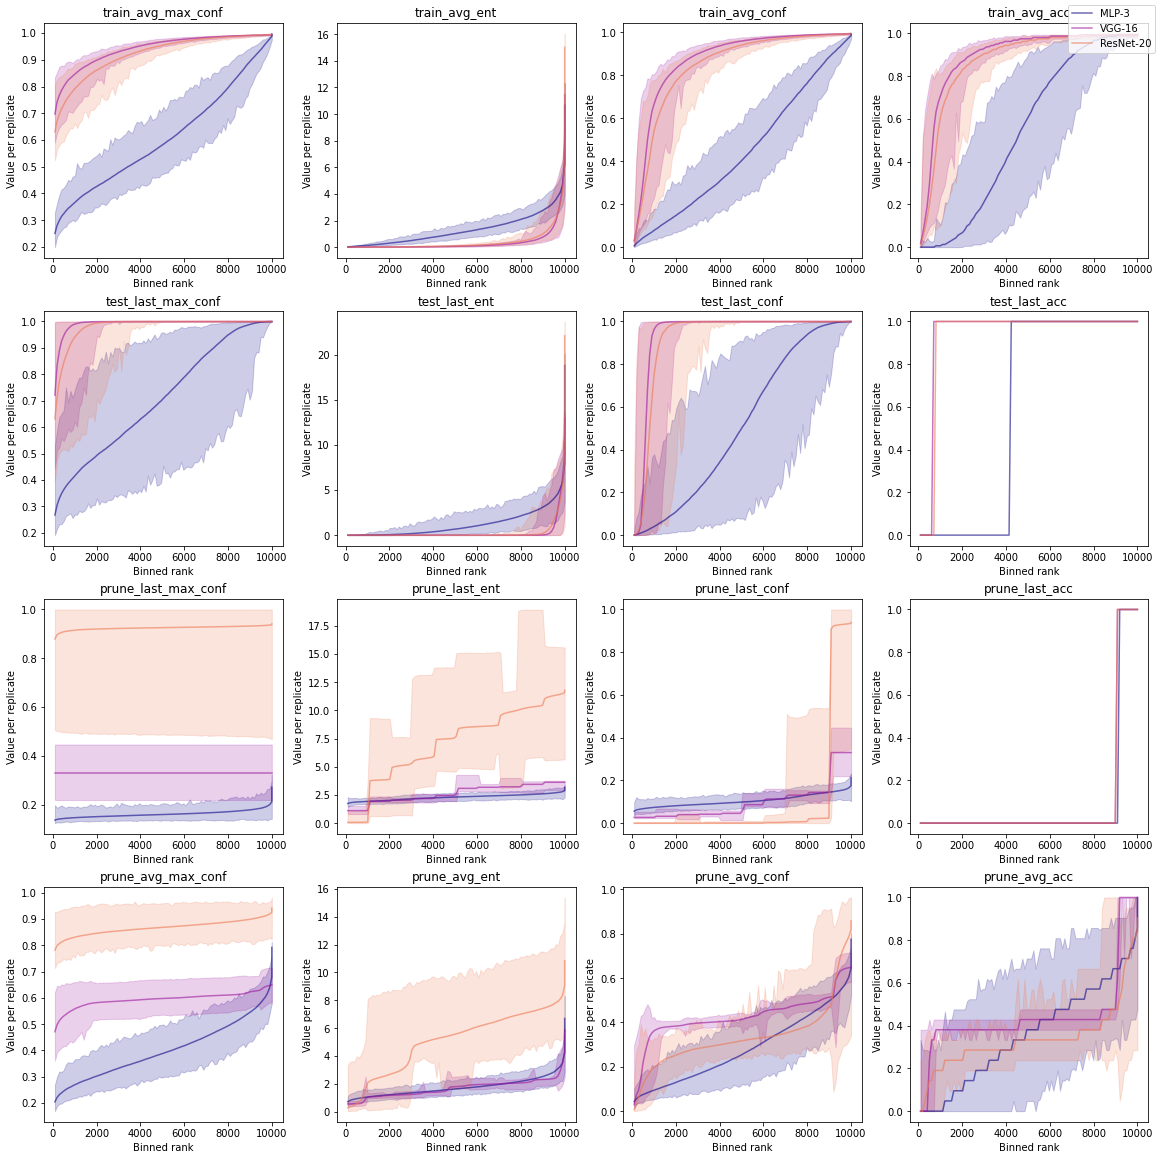

In [7]:
distributions_by_model(metrics_by_architecture, use_median=True)